In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv("carbon_footprint_dataset.csv")
df.head(10)


,energy_kwh,transport_km,waste_kg,carbon_emission_kg
0,1935.25,37.03,26.17,505.80
1,4758.50,108.38,24.70,1175.95
2,3686.77,174.59,90.63,1058.81
3,3033.43,146.44,24.95,782.46
4,864.49,161.31,27.19,284.25
5,864.37,131.76,75.94,365.76
6,384.61,138.46,44.97,199.64
7,4344.26,169.84,77.67,1187.69
8,3045.46,49.93,6.54,731.84
9,3569.56,97.88,48.76,940.03


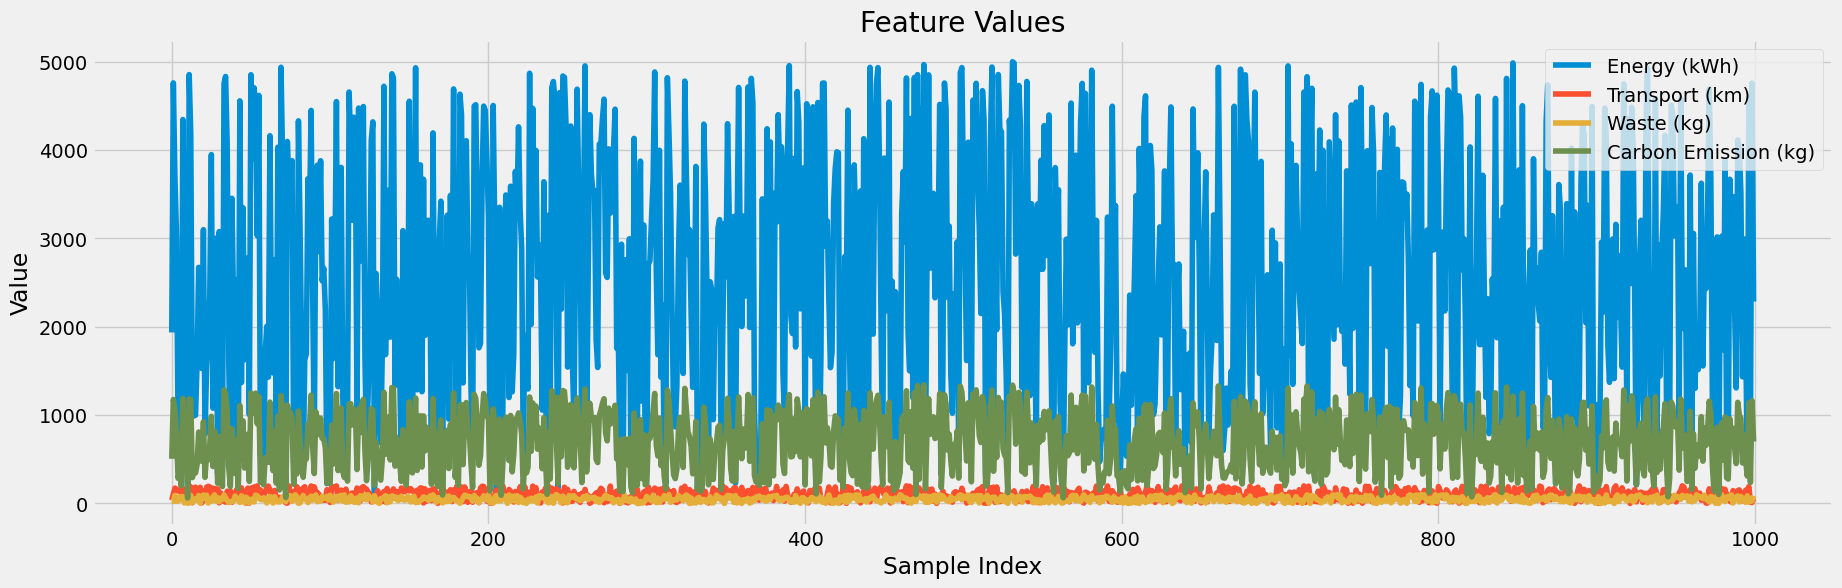

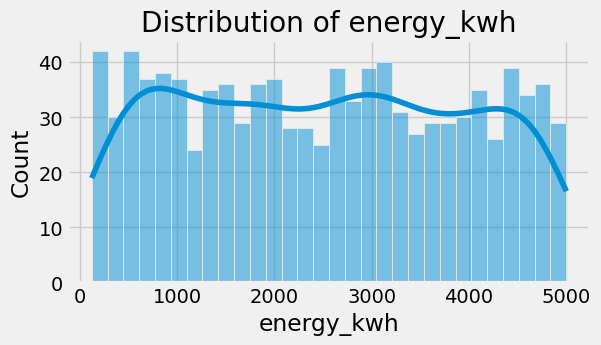

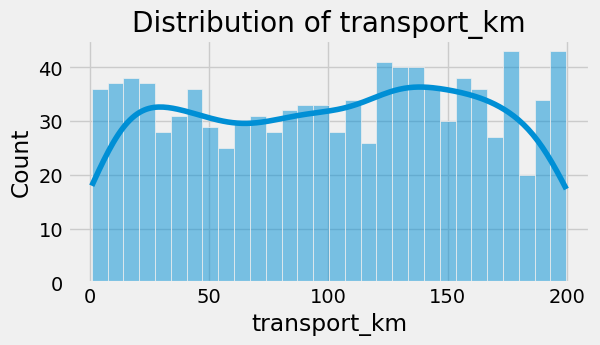

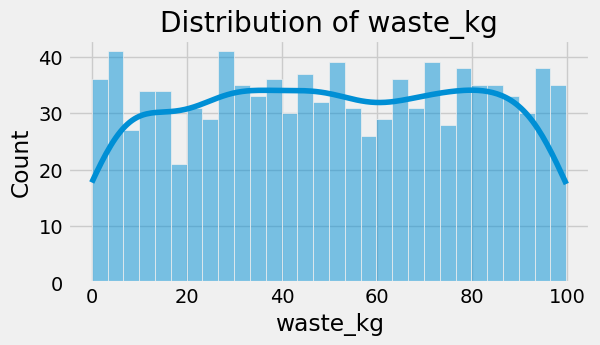

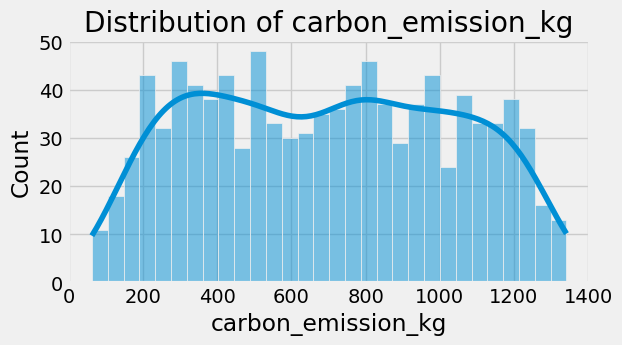

In [3]:
plt.figure(figsize=(20, 6))
plt.plot(df["energy_kwh"], label="Energy (kWh)")
plt.plot(df["transport_km"], label="Transport (km)")
plt.plot(df["waste_kg"], label="Waste (kg)")
plt.plot(df["carbon_emission_kg"], label="Carbon Emission (kg)")
plt.title("Feature Values")
plt.xlabel("Sample Index")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.show()

for col in df.columns:
    plt.figure(figsize=(6, 3))
    sns.histplot(df[col], kde=True, bins=30)
    plt.title(f"Distribution of {col}")
    plt.show()

In [4]:
print("Data Summary:")
print(df.describe())

Data Summary:
       energy_kwh  transport_km     waste_kg  carbon_emission_kg
count  1000.00000   1000.000000  1000.000000         1000.000000
mean   2502.25719    101.403370    50.240380          694.753710
std    1431.47318     58.438005    29.067298          338.989942
min     122.70000      0.640000     0.000000           62.140000
25%    1256.26750     48.215000    26.135000          397.852500
50%    2534.35500    103.745000    50.060000          699.075000
75%    3747.16750    152.095000    75.910000          980.207500
max    4998.62000    199.880000    99.780000         1341.600000


In [5]:
print("\nMissing Values:")
print(df.isnull().sum())


Missing Values:
energy_kwh            0
transport_km          0
waste_kg              0
carbon_emission_kg    0
dtype: int64


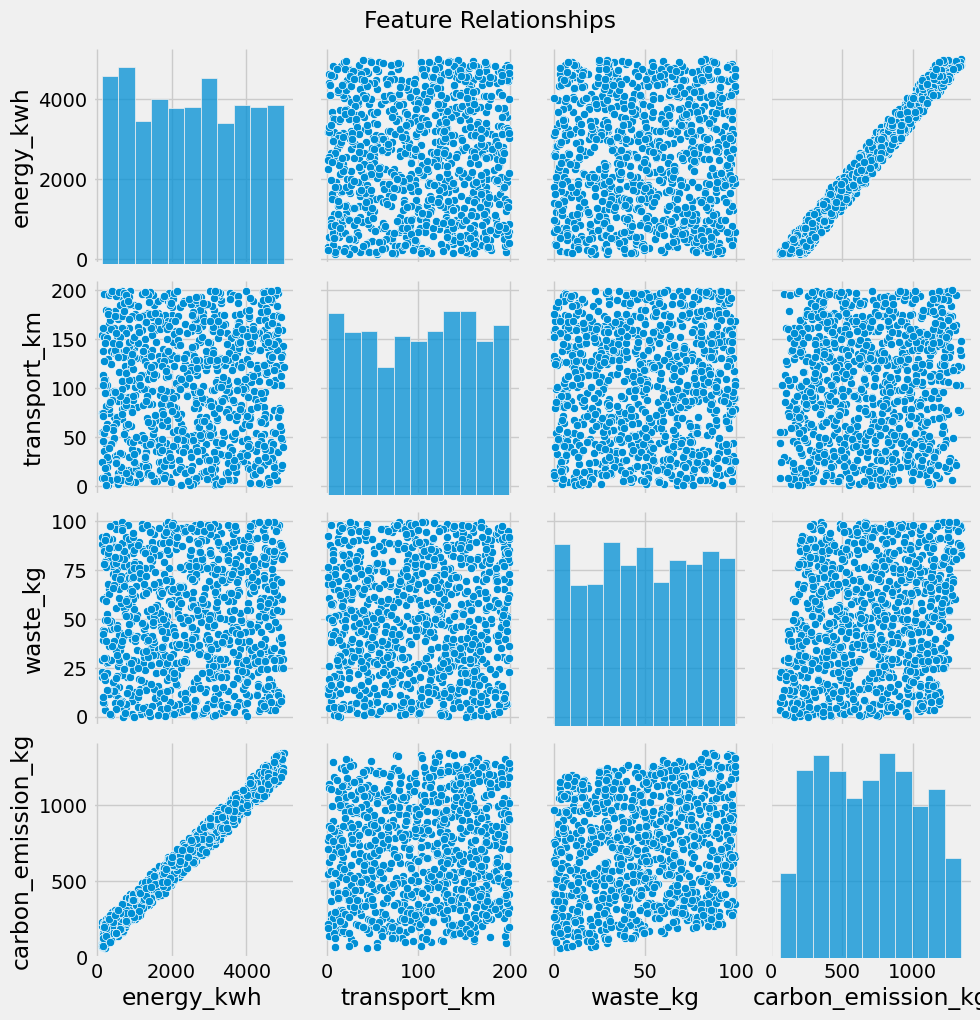

In [6]:
sns.pairplot(df)
plt.suptitle("Feature Relationships", y=1.02)
plt.show()

In [7]:
df['energy_transport_interaction'] = df['energy_kwh'] * df['transport_km']
df['energy_waste_interaction'] = df['energy_kwh'] * df['waste_kg']

In [8]:
X = df[["energy_kwh", "transport_km", "waste_kg", 
        "energy_transport_interaction", "energy_waste_interaction"]]
y = df["carbon_emission_kg"]


In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

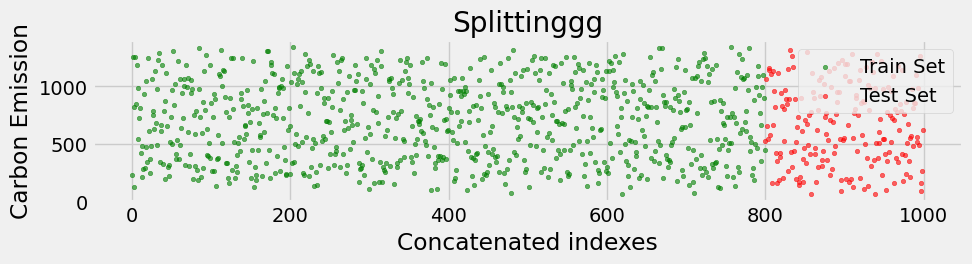

In [10]:
plt.figure(figsize=(10, 2))
plt.scatter(range(len(y_train)), y_train, label="Train Set", alpha=0.6, color="green", s=10)
plt.scatter(np.arange(len(y_train), len(y_train)+len(y_test)), y_test, label="Test Set", alpha=0.6, color="red", s=10)
plt.legend()
plt.title("Splittinggg")
plt.xlabel("Concatenated indexes")
plt.ylabel("Carbon Emission")
plt.grid(True)
plt.show()

In [11]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [12]:
xgb_model = XGBRegressor(random_state=42, objective='reg:squarederror')

In [13]:
#hyperparameter tunning
#defining parameter grid
param_grid = {
    'n_estimators': [50, 100, 150],    
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}

#grid search with cross validation
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

print("\nStarting hyperparameter tuning...")
grid_search.fit(X_train_scaled, y_train)
#filtering the best parameters
best_xgb = grid_search.best_estimator_
print("\nBest Parameters:", grid_search.best_params_)


Starting hyperparameter tuning...
Fitting 5 folds for each of 243 candidates, totalling 1215 fits

Best Parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 150, 'subsample': 0.9}


In [14]:
y_pred_train = best_xgb.predict(X_train_scaled)
y_pred_test = best_xgb.predict(X_test_scaled)

In [15]:
train_mse = mean_squared_error(y_train, y_pred_train)
test_mse = mean_squared_error(y_test, y_pred_test)
train_mae = mean_absolute_error(y_train, y_pred_train)
test_mae = mean_absolute_error(y_test, y_pred_test)
train_r2 = r2_score(y_train, y_pred_train)
test_r2 = r2_score(y_test, y_pred_test)

In [16]:
print("\nModel Evaluation:")
print("------------------")
print(f"Training MSE: {train_mse:.2f} | Test MSE: {test_mse:.2f}")
print(f"Training MAE: {train_mae:.2f} | Test MAE: {test_mae:.2f}")
print(f"Training R²: {train_r2:.4f} | Test R²: {test_r2:.4f}")


Model Evaluation:
------------------
Training MSE: 5.75 | Test MSE: 104.59
Training MAE: 1.87 | Test MAE: 8.11
Training R²: 0.9999 | Test R²: 0.9991


In [17]:
feature_importance = best_xgb.feature_importances_
features = X.columns
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importance})
importance_df = importance_df.sort_values('Importance', ascending=False)

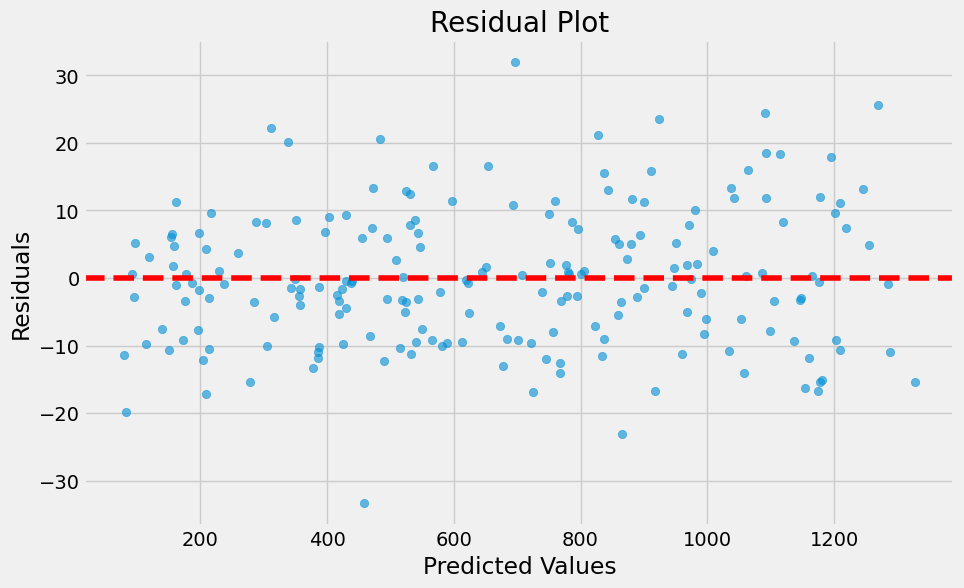

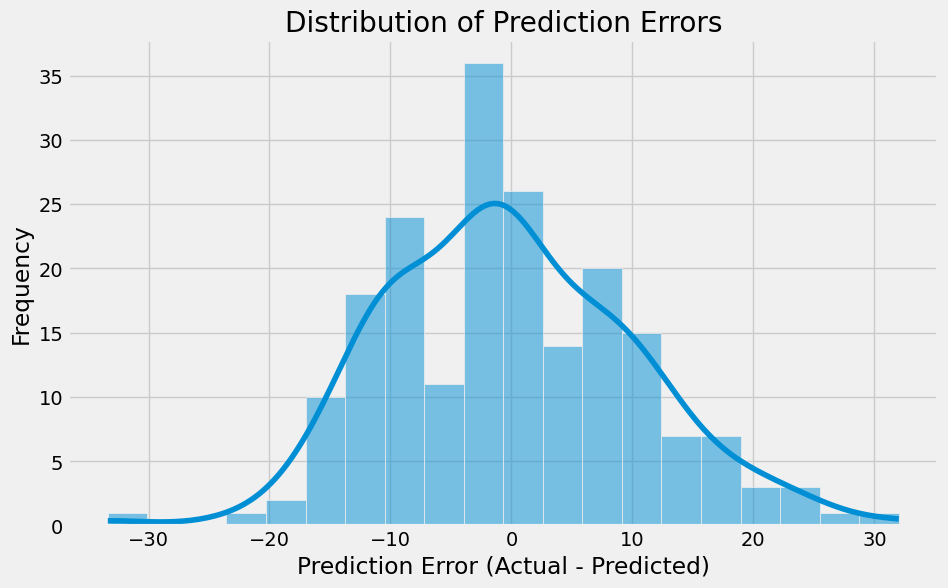

In [18]:
residuals = y_test - y_pred_test
plt.figure(figsize=(10, 6))
plt.scatter(y_pred_test, residuals, alpha=0.6)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True, bins=20)
plt.xlabel('Prediction Error (Actual - Predicted)')
plt.ylabel('Frequency')
plt.title('Distribution of Prediction Errors')
plt.grid(True)
plt.show()

In [21]:
best_xgb.save_model("xmodel.json")  
joblib.dump(scaler, "xscaler.pkl")

import json
with open("metadata.json", "w") as f:
    json.dump({
        "feature_order": ["energy_kwh", "transport_km", "waste_kg"],
        "interaction_terms": {
            "energy_transport": "energy_kwh * transport_km",
            "energy_waste": "energy_kwh * waste_kg"
        },
        "model_type": "XGBRegressor",
        "version": "1.0"
    }, f)

print("Model assets saved successfully:")
print("- xmodel.json (model weights)")
print("- scaler.pkl (feature scaler)")
print("- metadata.json (feature specs)")

Model assets saved successfully:
- xmodel.json (model weights)
- scaler.pkl (feature scaler)
- metadata.json (feature specs)
